In [2]:
import pandas as pd
import os


In [3]:
LLM_score_thresh = 0.82
enrichr_adj_pval_thresh = 0.05
enrichr_JI_thresh = 0.1
coverage_thresh = 0.2

## TODO: LLM Coverage/JI
To be even handed, we need to process the LLM analyses to determine how many genes are used to support the chosen name.

Plan: present the 300 analyses to an LLM to extract the genes supporting the name and the genes discussed.

## Load the Enrichr query data

In [4]:

import os
import pandas as pd

# Read the TSV file into a Pandas DataFrame
LLM_genes_DF = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_DF.tsv", delimiter="\t")
#LLM_genes_DF.shape
LLM_genes_DF.head(5)

,Unnamed: 0.1,Unnamed: 0,Source,GeneSetID,GeneSetName,GeneList,n_Genes,LLM Name,LLM Analysis,Score,Rank,Overlap,P-value,Adjusted P-value,Genes,Term,GO term,GO ID,GO_term_genes,LLM_name_GO_term_sim
0,0,0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,0,2/21,0.000069,0.008264,PLA2G1B;HSD17B14,Lipid Catabolic Process (GO:0016042),Lipid Catabolic Process,GO:0016042,CES1 PNLIPRP1 PLA2G1B CES1P1 AOAH HSD17B14 APO...,0.603573
1,1,0,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,0,2/85,0.001146,0.050873,PLA2G1B;MR1,Defense Response To Gram-positive Bacterium (G...,Defense Response To Gram-positive Bacterium,GO:0050830,GBP7 CHGA GBP6 GSDMD DEFB104A H2BC8 RNASE12 RN...,0.317063
2,2,0,NeST,Cluster1-12,Cluster1-12,AMY2B CNPY2 EGFL7 LDLR LPL LRP8 LRPAP1 MYLIP P...,12,Lipid Metabolism and Receptor-Mediated Endocyt...,"1. AMY2B (Amylase, alpha 2B) is an enzyme that...",0.88,0,4/189,0.000004,0.000671,VLDLR;SORL1;LRP8;LDLR,Endocytosis (GO:0006897),Endocytosis,GO:0006897,RALBP1 SCARA5 TBC1D2B AP1S1 TSC2 ARHGAP27 TICA...,0.607433
3,3,1,NeST,Cluster1-12,Cluster1-12,AMY2B CNPY2 EGFL7 LDLR LPL LRP8 LRPAP1 MYLIP P...,12,Lipid Metabolism and Receptor-Mediated Endocyt...,"1. AMY2B (Amylase, alpha 2B) is an enzyme that...",0.88,1,2/6,0.000005,0.000671,LRPAP1;LDLR,Negative Regulation Of Lipoprotein Particle Cl...,Negative Regulation Of Lipoprotein Particle Cl...,GO:0010985,KHSRP APOC3 APOC2 PCSK9 LDLR LRPAP1,0.440780
4,4,2,NeST,Cluster1-12,Cluster1-12,AMY2B CNPY2 EGFL7 LDLR LPL LRP8 LRPAP1 MYLIP P...,12,Lipid Metabolism and Receptor-Mediated Endocyt...,"1. AMY2B (Amylase, alpha 2B) is an enzyme that...",0.88,2,4/233,0.000008,0.000671,RELN;VLDLR;SORL1;LRP8,Positive Regulation Of Developmental Process (...,Positive Regulation Of Developmental Process,GO:0051094,ACVR1 KRT2 ISL1 SMARCA2 SMARCA4 CDC20 NEURL1 T...,0.150215


## Common functions

In [6]:
# functions to compute the Jaccard Index and coverage for the query gene list and the GO term genes
def get_JI(GeneList: str, enrichr_genes) -> float:
    # Check if enrichr_genes is a string
    if not isinstance(enrichr_genes, str):
        #print(f"Warning: enrichr_genes is not a string: {enrichr_genes}")
        return 0
    
    # Assume separation is the same
    geneSetGenes = GeneList.split(" ")
    enrichRGenes = enrichr_genes.split(" ")
    
    # Calculate the Jaccard Index (JI)
    intersection = set(geneSetGenes).intersection(set(enrichRGenes))
    union = set(geneSetGenes).union(set(enrichRGenes))
    
    JI = len(intersection) / len(union) if len(union) != 0 else 0
    
    return JI

def get_coverage(GeneList: str, enrichr_genes) -> float:
    # Check if enrichr_genes is a string
    if not isinstance(enrichr_genes, str):
        #print(f"Warning: enrichr_genes is not a string: {enrichr_genes}")
        return 0
    
    # Assume separation is the same
    geneSetGenes = GeneList.split(" ")
    enrichRGenes = enrichr_genes.split(" ")
    
    # Calculate the intersection
    intersection = set(geneSetGenes).intersection(set(enrichRGenes))
    
    # Calculate the coverage
    coverage = len(intersection) / len(geneSetGenes) if len(geneSetGenes) != 0 else 0
    
    return coverage

def create_success_contingency_table(df):
    # Make the LLM vs enrichr contingency table
    contingency_table = pd.crosstab(df['enrichr_success_TF'], df['LLM_success_TF'], rownames=['enrichr_success_TF'], colnames=['LLM_success_TF'])

    # Reorder the rows and columns
    contingency_table = contingency_table.reindex(index=[True, False], columns=[True, False])

    # Add the total column and row
    contingency_table['Total'] = contingency_table.sum(axis=1)
    contingency_table.loc['Total'] = contingency_table.sum(axis=0)

    return contingency_table

def select_rows_and_columns(df, number_of_rows=None):
    # Specify the ordered list of column names you want to return
    ordered_column_names = [
        'n_Genes', 'GeneList', 'LLM Name', 'Score', 'GO term', 'GO_term_genes',
        'Genes', 'Overlap', 'Adjusted P-value', 'coverage', 'enrichr_JI', 
        'LLM_success_TF', 'enrichr_success_TF'
    ]
    
    # If number_of_rows is not specified, select all rows
    if number_of_rows is None:
        result_df = df.loc[:, ordered_column_names]
    else:
        result_df = df.loc[:, ordered_column_names].head(number_of_rows)
    
    return result_df

## Add JI and coverage scores

In [7]:
# Apply the get_JI and get_coverage functions to each row and add new columns to the DataFrame
LLM_genes_DF['enrichr_JI'] = LLM_genes_DF.apply(lambda row: get_JI(row['GeneList'], 
                                                                   row['GO_term_genes']), 
                                                                   axis=1)

LLM_genes_DF['coverage'] = LLM_genes_DF.apply(lambda row: get_coverage(row['GeneList'], 
                                                                   row['GO_term_genes']), 
                                                                   axis=1)
LLM_genes_DF.shape

(11310, 22)

## Original: select Enrichr result with best JI, then threshold JI and APV

In [8]:
# Reproducing the original analysis:

# create a DataFrame reduced_LLM_genes_by_JI_DF containing the rows with the highest enrichr_JI 
# for each combination of Source, GeneSetID, GeneSetName, GeneList.
grouped = LLM_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Define a function to return the row with the maximum 'enrichr_JI' for each group
def get_max_enrichr_JI(df):
    return df.loc[df['enrichr_JI'].idxmax()]

# Apply the function to each group and reset the index
# We take the GO term with the highest Jaccard Index
reduced_LLM_genes_by_JI_DF = grouped.apply(get_max_enrichr_JI).reset_index(drop=True)

# Add the LLM_success_TF and enrichr_success_TF columns
# LLM_success_TF is True if the 'Score' is greater than or equal to LLM_score_thresh
# enrichr_success_TF is False if the 'Adjusted P-value' is less or equal to  enrichr_adj_pval_thresh and the 'enrichr_JI' is greater than or equal to enrichr_JI_thresh
reduced_LLM_genes_by_JI_DF['LLM_success_TF'] = reduced_LLM_genes_by_JI_DF['Score'] >= LLM_score_thresh
reduced_LLM_genes_by_JI_DF['enrichr_success_TF'] = ~((reduced_LLM_genes_by_JI_DF['Adjusted P-value'] > enrichr_adj_pval_thresh) | (reduced_LLM_genes_by_JI_DF['enrichr_JI'] < enrichr_JI_thresh))

# Print the contingency table
print(create_success_contingency_table(reduced_LLM_genes_by_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_JI_DF, 5)
result_df

LLM_success_TF      True  False  Total
enrichr_success_TF                    
True                  36      4     40
False                 97    163    260
Total                133    167    300


,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,Regulation Of Peroxisome Proliferator Activate...,ASXL2 ASXL1 PTGIS BMP2 CITED2 GPS2 LMO3 PLIN5 ...,CITED2;TWIST1,2/10,0.023830,0.083333,0.062500,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,Response To Steroid Hormone,MED1 TGFB1 PAQR7 TGFB3 PAQR8 TGFB2 HSPA8 NR1H3...,CAV1;AKR1B1;THBS1,3/29,0.047162,0.050847,0.035294,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,B Cell Chemotaxis,HSD3B7 CXCL13 PIK3CD CYP7B1 GAS6,GAS6,1/5,0.037716,0.111111,0.076923,False,False
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,ERK1 And ERK2 Cascade,DUSP5 DUSP6 EGF MAP2K2 MAP2K1 KARS1 PTGER4 ZFP...,CTSH;SOX9,2/24,0.010442,0.133333,0.054054,False,False


In [9]:
reduced_LLM_genes_by_JI_DF_novel = reduced_LLM_genes_by_JI_DF.loc[(reduced_LLM_genes_by_JI_DF['enrichr_success_TF'] == False)& (reduced_LLM_genes_by_JI_DF['LLM_success_TF'] == True), ['GeneSetID','n_Genes', 'GeneList', 'LLM Name', 'Score', 'GO term', 'GO_term_genes',
        'Genes', 'Overlap', 'Adjusted P-value', 'coverage', 'enrichr_JI', 
        'LLM_success_TF', 'enrichr_success_TF']]

## Alt #1: Select Enrichr result with best APV, then threshold JI and APV

In [10]:
# Alternative analysis in which the reduced DF is based on selecting by the minimum of Adjusted P-value

# create a DataFrame reduced_LLM_genes_by_apv_DF containing the rows with the lowest 'Adjusted P-value' 
# for each combination of Source, GeneSetID, GeneSetName, GeneList.

# Group the DataFrame by the specified columns
grouped = LLM_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Define a function to return the row with the minimum 'Adjusted P-value' for each group
def get_min_adj_p_value(df):
    return df.loc[df['Adjusted P-value'].idxmin()]

# Apply the function to each group and reset the index
reduced_LLM_genes_by_apv_DF = grouped.apply(get_min_adj_p_value).reset_index(drop=True)

# Add the LLM_success_TF and enrichr_success_TF columns
reduced_LLM_genes_by_apv_DF['LLM_success_TF'] = reduced_LLM_genes_by_apv_DF['Score'] >= LLM_score_thresh

# The resulting DataFrame will have an enrichr_success_TF column where the values are True if both conditions 
# (Adjusted P-value >= enrichr_adj_pval_thresh) and (enrichr_JI <= enrichr_JI_thresh) are met. 
# Otherwise, it will be False.
reduced_LLM_genes_by_apv_DF['enrichr_success_TF'] = ~((reduced_LLM_genes_by_apv_DF['Adjusted P-value'] > enrichr_adj_pval_thresh) | (reduced_LLM_genes_by_apv_DF['enrichr_JI'] < enrichr_JI_thresh))

# Print the contingency table
print(create_success_contingency_table(reduced_LLM_genes_by_apv_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_apv_DF, 5)
result_df

LLM_success_TF      True  False  Total
enrichr_success_TF                    
True                  21      4     25
False                112    163    275
Total                133    167    300


,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,Regulation Of Peroxisome Proliferator Activate...,ASXL2 ASXL1 PTGIS BMP2 CITED2 GPS2 LMO3 PLIN5 ...,CITED2;TWIST1,2/10,0.023830,0.083333,0.062500,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,Response To Steroid Hormone,MED1 TGFB1 PAQR7 TGFB3 PAQR8 TGFB2 HSPA8 NR1H3...,CAV1;AKR1B1;THBS1,3/29,0.047162,0.050847,0.035294,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,Positive Regulation Of Protein Tyrosine Kinase...,PTPN1 IL34 ACE EGF FBXW7 SRCIN1 PRNP AGT EREG ...,GAS6;AREG,2/38,0.023945,0.222222,0.044444,False,False
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,SMAD Protein Signal Transduction,GDF11 TGFB1 TGFB3 JUN TGFB2 GDF15 BMP8B BMP8A ...,NUP93;GDF15;INHBB,3/51,0.002024,0.200000,0.047619,False,False


## Alt #2 Select Enrichr result with best APV, threshold on APV, no JI requirement

In [11]:
# Alternative analysis in which the reduced DF is based on the minimum of Adjusted P-value with no JI requirement

# create a DataFrame reduced_LLM_genes_by_apv_DF containing the rows with the lowest 'Adjusted P-value' 
# for each combination of Source, GeneSetID, GeneSetName, GeneList.

# Group the DataFrame by the specified columns
grouped = LLM_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Define a function to return the row with the minimum 'Adjusted P-value' for each group
def get_min_adj_p_value(df):
    return df.loc[df['Adjusted P-value'].idxmin()]

# Apply the function to each group and reset the index
reduced_LLM_genes_by_apv_no_JI_DF = grouped.apply(get_min_adj_p_value).reset_index(drop=True)

# Add the LLM_success_TF and enrichr_success_TF columns
reduced_LLM_genes_by_apv_no_JI_DF['LLM_success_TF'] = reduced_LLM_genes_by_apv_DF['Score'] >= LLM_score_thresh

# The resulting DataFrame will have an enrichr_success_TF column where the values are True if both conditions 
# (Adjusted P-value >= enrichr_adj_pval_thresh) and (enrichr_JI <= enrichr_JI_thresh) are met. 
# Otherwise, it will be False.
reduced_LLM_genes_by_apv_no_JI_DF['enrichr_success_TF'] = ~(reduced_LLM_genes_by_apv_DF['Adjusted P-value'] > enrichr_adj_pval_thresh)

# Print the contingency table
print(create_success_contingency_table(reduced_LLM_genes_by_apv_no_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_apv_no_JI_DF, 5)
result_df

LLM_success_TF      True  False  Total
enrichr_success_TF                    
True                 117    103    220
False                 16     64     80
Total                133    167    300


,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,Regulation Of Peroxisome Proliferator Activate...,ASXL2 ASXL1 PTGIS BMP2 CITED2 GPS2 LMO3 PLIN5 ...,CITED2;TWIST1,2/10,0.023830,0.083333,0.062500,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,Response To Steroid Hormone,MED1 TGFB1 PAQR7 TGFB3 PAQR8 TGFB2 HSPA8 NR1H3...,CAV1;AKR1B1;THBS1,3/29,0.047162,0.050847,0.035294,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,Positive Regulation Of Protein Tyrosine Kinase...,PTPN1 IL34 ACE EGF FBXW7 SRCIN1 PRNP AGT EREG ...,GAS6;AREG,2/38,0.023945,0.222222,0.044444,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,SMAD Protein Signal Transduction,GDF11 TGFB1 TGFB3 JUN TGFB2 GDF15 BMP8B BMP8A ...,NUP93;GDF15;INHBB,3/51,0.002024,0.200000,0.047619,False,True


In [12]:
reduced_LLM_genes_by_apv_no_JI_DF.loc[(reduced_LLM_genes_by_apv_no_JI_DF['enrichr_success_TF'] == False)& (reduced_LLM_genes_by_apv_no_JI_DF['LLM_success_TF'] == True), ['n_Genes', 'GeneList', 'LLM Name', 'Score', 'GO term', 'GO_term_genes',
        'Genes', 'Overlap', 'Adjusted P-value', 'coverage', 'enrichr_JI', 
        'LLM_success_TF', 'enrichr_success_TF']]

,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
5,38,1060P11.3 ADH5 ADM ATF3 CASP1 CLEC2B CPA3 CRIM...,Stress Response and Apoptosis Regulation,0.85,Axon Regeneration,GAP43 RTN4RL1 RTN4RL2 TNC NREP MTR MAPK8IP3 FO...,TNC;FOLR1,2/9,0.059855,0.052632,0.044444,True,False
12,63,1060P11.3 ACTN1 AMIGO2 ANKRD10 ATP11B C1QA C1Q...,Immune Response and Extracellular Matrix Organ...,0.85,Commissural Neuron Axon Guidance,NELL1 RYK NFIB GDNF NCAM1 SMO EPHB2 VEGFA,NFIB;VEGFA,2/8,0.067674,0.031746,0.028986,True,False
26,25,1060P11.3 AZGP1 CD40 CD58 DMXL2 FGL2 GOLM1 IGJ...,Immune Response and Signal Transduction,0.85,Cellular Response To Cadmium Ion,DAXX JUN CHUK SLC11A1 FOS MT1X MMP9 EGFR MAPK9...,JUN;SLC39A8,2/22,0.068962,0.080000,0.044444,True,False
28,14,CDH1 FCER1A GLIPR1 GOLGA8A GOLGA8B PHLDA2 PLAG...,Cellular Adhesion and Signal Transduction in C...,0.85,Response To Lithium Ion,SLC13A2 CDKN1B SLC13A5 IMPA2 CDH1,CDH1,1/5,0.066544,0.071429,0.055556,True,False
29,75,1060P11.3 AQP3 BASP1 BNIP3L BTG1 C6ORF48 CCNG2...,Cellular Stress Response and Apoptosis Regulation,0.85,Negative Regulation Of Cellular Process,BTBD18 ATG13 GTPBP4 SPINT2 MYL2 AGTR2 CDK10 HS...,RNF167;IFITM1;BTG1;CDKN1B;ERBB3;RB1CC1;TXNIP;P...,9/537,0.062848,0.120000,0.014925,True,False
54,22,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,Regulation of Cellular Metabolism and Stress R...,0.85,Response To Cytokine,TLE5 CD74 IL1R1 MX1 MX2 FOXH1 LIFR POU4F1 POU4...,BST2;COL3A1;LEF1,3/125,0.068971,0.136364,0.020833,True,False
69,16,1060P11.3 DNAJB1 FOSL1 GCLM HLA-DQA1 HLA-DQB1 ...,Cellular Stress Response and Immune Regulation,0.85,Regulation Of Cellular Response To Stress,RADX AMFR WDR76 CORO2B SUPT7L DEPDC1B PINK1 NU...,DNAJB1;ALOX5,2/107,0.073348,0.125000,0.016529,True,False
117,49,1060P11.3 ADH1B CD48 CHI3L1 FCER1A FGL2 FRY GP...,Immune Response and Inflammation,0.85,Negative Regulation Of Cell-Cell Adhesion Medi...,NOTCH4 EPCAM NOTCH1 RGCC NEXMIF PLG PPM1F VEGF...,RGCC;EPCAM,2/9,0.075090,0.040816,0.035714,True,False
127,12,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,Lipid Metabolism and Membrane Trafficking,0.85,Defense Response To Gram-positive Bacterium,GBP7 CHGA GBP6 GSDMD DEFB104A H2BC8 RNASE12 RN...,PLA2G1B;MR1,2/85,0.050873,0.166667,0.021053,True,False


## Alt #3: Select Enrichr result with best APV that also meets JI threshold

In [13]:
# Alternative analysis in which the result is selected as the row with the lowest Adjusted P-value that passes both requirements
grouped = LLM_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Define a function to filter and select the appropriate row
def filter_and_select(df):
    # Filter rows that pass both Enrichr requirements
    filtered = df[(df['enrichr_JI'] >= enrichr_JI_thresh) & (df['Adjusted P-value'] <= enrichr_adj_pval_thresh)]
    
    if not filtered.empty:
        # If there are rows that pass both requirements, select the one with the lowest adjusted p-value
        return filtered.loc[filtered['Adjusted P-value'].idxmin()]
    else:
        # If no rows pass both requirements, select the one with the lowest adjusted p-value in the original group
        return df.loc[df['Adjusted P-value'].idxmin()]

# Apply the function to each group and reset the index
reduced_LLM_genes_by_apv_best_DF = grouped.apply(filter_and_select).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'enrichr_success_TF' columns
reduced_LLM_genes_by_apv_best_DF['LLM_success_TF'] = reduced_LLM_genes_by_apv_best_DF['Score'] >= LLM_score_thresh
reduced_LLM_genes_by_apv_best_DF['enrichr_success_TF'] = ~((reduced_LLM_genes_by_apv_best_DF['Adjusted P-value'] > enrichr_adj_pval_thresh) | (reduced_LLM_genes_by_apv_best_DF['enrichr_JI'] < enrichr_JI_thresh))

print(create_success_contingency_table(reduced_LLM_genes_by_apv_best_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_apv_best_DF, 5)
result_df

LLM_success_TF      True  False  Total
enrichr_success_TF                    
True                  36      4     40
False                 97    163    260
Total                133    167    300


,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,Regulation Of Peroxisome Proliferator Activate...,ASXL2 ASXL1 PTGIS BMP2 CITED2 GPS2 LMO3 PLIN5 ...,CITED2;TWIST1,2/10,0.023830,0.083333,0.062500,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,Response To Steroid Hormone,MED1 TGFB1 PAQR7 TGFB3 PAQR8 TGFB2 HSPA8 NR1H3...,CAV1;AKR1B1;THBS1,3/29,0.047162,0.050847,0.035294,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,Positive Regulation Of Protein Tyrosine Kinase...,PTPN1 IL34 ACE EGF FBXW7 SRCIN1 PRNP AGT EREG ...,GAS6;AREG,2/38,0.023945,0.222222,0.044444,False,False
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,SMAD Protein Signal Transduction,GDF11 TGFB1 TGFB3 JUN TGFB2 GDF15 BMP8B BMP8A ...,NUP93;GDF15;INHBB,3/51,0.002024,0.200000,0.047619,False,False


In [14]:
reduced_LLM_genes_by_apv_best_DF_novel = reduced_LLM_genes_by_apv_best_DF.loc[(reduced_LLM_genes_by_apv_best_DF['enrichr_success_TF'] == False)& (reduced_LLM_genes_by_apv_best_DF['LLM_success_TF'] == True), ['GeneSetID','n_Genes', 'GeneList', 'LLM Name', 'Score', 'GO term', 'GO_term_genes',
        'Genes', 'Overlap', 'Adjusted P-value', 'coverage', 'enrichr_JI', 
        'LLM_success_TF', 'enrichr_success_TF']]

In [15]:
# check if the gene lists are the same
print(reduced_LLM_genes_by_apv_best_DF_novel['GeneList'].equals(reduced_LLM_genes_by_JI_DF_novel['GeneList']))
# check if the GO terms are the same
print(reduced_LLM_genes_by_apv_best_DF_novel['GO term'].equals(reduced_LLM_genes_by_JI_DF_novel['GO term']))
# print the numbers of GO terms that are different from the original analysis
print(reduced_LLM_genes_by_apv_best_DF_novel.loc[reduced_LLM_genes_by_apv_best_DF_novel['GO term'] != reduced_LLM_genes_by_JI_DF_novel['GO term'], :].shape[0])
# get the gene set IDs 
diff_sets = reduced_LLM_genes_by_apv_best_DF_novel.loc[reduced_LLM_genes_by_apv_best_DF_novel['GO term'] != reduced_LLM_genes_by_JI_DF_novel['GO term'], 'GeneSetID']
# even though the contingent table is the same, the returned GO terms are different


True
False
41


## Alt #4: Select Enrichr result with best APV that also passes coverage threshold

In [16]:

# Define a function to filter and select the appropriate row
def filter_and_select_coverage(df):
    # Filter rows that pass both Enrichr requirements
    filtered = df[(df['coverage'] >= coverage_thresh) & (df['Adjusted P-value'] <= enrichr_adj_pval_thresh)]
    
    if not filtered.empty:
        # If there are rows that pass both requirements, select the one with the lowest adjusted p-value
        return filtered.loc[filtered['Adjusted P-value'].idxmin()]
    else:
        # If no rows pass both requirements, select the one with the lowest adjusted p-value in the original group
        return df.loc[df['Adjusted P-value'].idxmin()]

# Grouping the DataFrame by the specified columns
grouped = LLM_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Apply the function to each group and reset the index
reduced_LLM_genes_by_coverage_DF = grouped.apply(filter_and_select_coverage).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'enrichr_success_TF' columns
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = reduced_LLM_genes_by_coverage_DF['Score'] >= LLM_score_thresh
reduced_LLM_genes_by_coverage_DF['enrichr_success_TF'] = ~((reduced_LLM_genes_by_coverage_DF['Adjusted P-value'] > enrichr_adj_pval_thresh) | (reduced_LLM_genes_by_coverage_DF['coverage'] < coverage_thresh))

print(create_success_contingency_table(reduced_LLM_genes_by_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_coverage_DF, 5)
result_df

LLM_success_TF      True  False  Total
enrichr_success_TF                    
True                  72     17     89
False                 61    150    211
Total                133    167    300


,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,Regulation Of Peroxisome Proliferator Activate...,ASXL2 ASXL1 PTGIS BMP2 CITED2 GPS2 LMO3 PLIN5 ...,CITED2;TWIST1,2/10,0.023830,0.083333,0.062500,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,Response To Steroid Hormone,MED1 TGFB1 PAQR7 TGFB3 PAQR8 TGFB2 HSPA8 NR1H3...,CAV1;AKR1B1;THBS1,3/29,0.047162,0.050847,0.035294,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,Positive Regulation Of Protein Tyrosine Kinase...,PTPN1 IL34 ACE EGF FBXW7 SRCIN1 PRNP AGT EREG ...,GAS6;AREG,2/38,0.023945,0.222222,0.044444,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,SMAD Protein Signal Transduction,GDF11 TGFB1 TGFB3 JUN TGFB2 GDF15 BMP8B BMP8A ...,NUP93;GDF15;INHBB,3/51,0.002024,0.200000,0.047619,False,True


In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def coverage_thresholding(df, col, coverage_thresh_list = np.arange(0.0, 1.0, 0.1), enrichr_adj_pval_thresh = 0.05):

    # Initialize the result DataFrame with 0
    coverage_thresh_eval_DF = pd.DataFrame({
        'coverage_thresh': coverage_thresh_list,
        'perc_success': np.zeros(len(coverage_thresh_list)),
        'perc_meetsThresh': np.zeros(len(coverage_thresh_list)),
        'perc_success_normed': 100
    })

    # Loop through each coverage threshold
    for i, coverage_thresh in enumerate(coverage_thresh_list):
        # Calculate perc_success: percentage of rows that meet both the coverage and adjusted p-value thresholds
        coverage_threshCol = ((df['Adjusted P-value'] <= enrichr_adj_pval_thresh) & (df[col] >= coverage_thresh)) 

        coverage_thresh_eval_DF.loc[i, 'perc_success'] = (sum(coverage_threshCol) / len(df)) * 100
        # Calculate perc_success_normed: percentage of rows that meet both the coverage and adjusted p-value thresholds, normalized by the number of rows that meet the adjusted p-value threshold
        pval_threshCol = (df['Adjusted P-value'] <= enrichr_adj_pval_thresh)
        # print(sum(pval_threshCol))
        # print(sum(coverage_threshCol))
        coverage_thresh_eval_DF.loc[i, 'perc_success_normed'] = (sum(coverage_threshCol) / sum(pval_threshCol)) * 100
        
        # Calculate perc_meetsThresh: percentage of rows that meet the coverage threshold
        coverage_threshOnlyCol = (df[col] >= coverage_thresh)
        coverage_thresh_eval_DF.loc[i, 'perc_meetsThresh'] = (sum(coverage_threshOnlyCol) / len(df)) * 100
        
        # # Calculate accuracy
        # coverage_threshCol = coverage_threshCol.astype(int) # Convert boolean to integer
        # LLM_success_TF = df['LLM_success_TF'].astype(int)
        # if len(np.unique(coverage_threshCol)) > 1:
        #     c = confusion_matrix(coverage_threshCol, LLM_success_TF)
        #     coverage_thresh_eval_DF.loc[i, 'accuracy'] = (c[0, 0] + c[1, 1]) / c.sum()
        # else:
        #     coverage_thresh_eval_DF.loc[i, 'accuracy'] = np.nan  # Handle the case where the confusion matrix is not defined
    return coverage_thresh_eval_DF

coverage_thresh_eval_DF = coverage_thresholding(reduced_LLM_genes_by_coverage_DF, 'coverage')

# Display the result DataFrame
print(coverage_thresh_eval_DF)

    

   coverage_thresh  perc_success  perc_meetsThresh  perc_success_normed
0              0.0     73.333333        100.000000           100.000000
1              0.1     49.000000         54.666667            66.818182
2              0.2     29.666667         30.333333            40.454545
3              0.3     17.000000         17.000000            23.181818
4              0.4     10.000000         10.000000            13.636364
5              0.5      8.000000          8.000000            10.909091
6              0.6      6.000000          6.000000             8.181818
7              0.7      3.666667          3.666667             5.000000
8              0.8      2.333333          2.333333             3.181818
9              0.9      0.333333          0.333333             0.454545


In [48]:
JI_thresh_eval_DF = coverage_thresholding(reduced_LLM_genes_by_apv_best_DF, 'enrichr_JI', coverage_thresh_list = np.arange(0.0, 1.0, 0.05))

# Display the result DataFrame
print(JI_thresh_eval_DF)

    coverage_thresh  perc_success  perc_meetsThresh  perc_success_normed
0              0.00     73.333333        100.000000           100.000000
1              0.05     35.333333         36.000000            48.181818
2              0.10     13.333333         13.333333            18.181818
3              0.15      3.333333          3.333333             4.545455
4              0.20      1.000000          1.000000             1.363636
5              0.25      0.666667          0.666667             0.909091
6              0.30      0.000000          0.000000             0.000000
7              0.35      0.000000          0.000000             0.000000
8              0.40      0.000000          0.000000             0.000000
9              0.45      0.000000          0.000000             0.000000
10             0.50      0.000000          0.000000             0.000000
11             0.55      0.000000          0.000000             0.000000
12             0.60      0.000000          0.000000

In [49]:
JI_thresh_eval_DF = coverage_thresholding(reduced_LLM_genes_by_JI_DF, 'enrichr_JI', coverage_thresh_list = np.arange(0.0, 1.0, 0.05))

# Display the result DataFrame
print(JI_thresh_eval_DF)

    coverage_thresh  perc_success  perc_meetsThresh  perc_success_normed
0              0.00     73.333333        100.000000           100.000000
1              0.05     46.666667         47.333333            63.636364
2              0.10     13.333333         13.333333            18.181818
3              0.15      4.333333          4.333333             5.909091
4              0.20      1.333333          1.333333             1.818182
5              0.25      1.000000          1.000000             1.363636
6              0.30      0.000000          0.000000             0.000000
7              0.35      0.000000          0.000000             0.000000
8              0.40      0.000000          0.000000             0.000000
9              0.45      0.000000          0.000000             0.000000
10             0.50      0.000000          0.000000             0.000000
11             0.55      0.000000          0.000000             0.000000
12             0.60      0.000000          0.000000

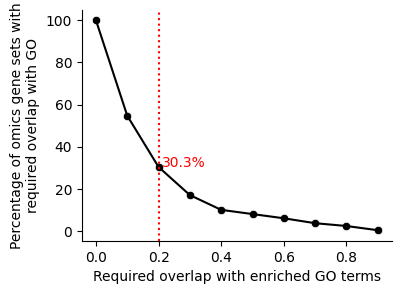

In [56]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_meetsThresh', color='black')
sns.lineplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_meetsThresh', color='black')

# Adding vertical lines at specific thresholds
plt.axvline(x=0.2, color='red', linestyle='dotted')
# label the line as the percentage of omics gene sets that meet the threshold
perc_meetsThresh = coverage_thresh_eval_DF.loc[coverage_thresh_eval_DF['coverage_thresh'] == 0.2, 'perc_meetsThresh'].values[0]
plt.text(0.2+0.15, perc_meetsThresh, f'{perc_meetsThresh:.1f}%', color='red', ha='right')
# Adding labels and title
plt.xlabel('Required overlap with enriched GO terms')
plt.ylabel('Percentage of omics gene sets with\nrequired overlap with GO')
sns.despine()

# Display the plot
plt.show()

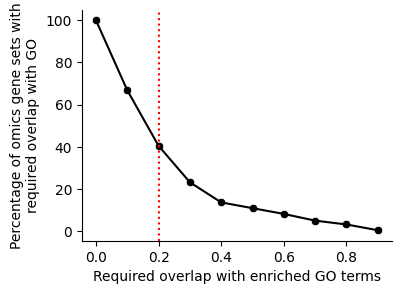

In [31]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_success_normed', color='black')
sns.lineplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_success_normed', color='black')

# Adding vertical lines at specific thresholds
plt.axvline(x=0.2, color='red', linestyle='dotted')

# Adding labels and title
plt.xlabel('Required overlap with enriched GO terms')
plt.ylabel('Percentage of omics gene sets with\nrequired overlap with GO')
sns.despine()

# Display the plot
plt.show()

In [16]:
# # Write the DataFrames to TSV files
# reduced_LLM_genes_by_JI_DF.to_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_JI_DF.tsv", sep="\t", index=False)
# reduced_LLM_genes_by_apv_DF.to_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_apv_DF.tsv", sep="\t", index=False)
# reduced_LLM_genes_by_apv_best_DF.to_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_apv_best_JI.tsv", sep="\t", index=False)

# # also save the dataframes that the GOterms differe between these two 
# diff_go_df = reduced_LLM_genes_by_apv_best_DF.loc[reduced_LLM_genes_by_apv_best_DF['GeneSetID'].isin(diff_sets), :]
# print(diff_go_df.shape)
# diff_go_df.to_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_apv_best_JI_dff.tsv", sep="\t", index=False)

## Translated R analysis

~~~

get_JI = function(GeneList, enrichr_genes){
    # assume separation is the same
    geneSetGenes = str_split(string = GeneList, pattern = " ")[[1]]
    enrichRGenes = str_split(string = enrichr_genes, pattern = " ")[[1]]
    JI = length(intersect(geneSetGenes, enrichRGenes))/ length(union(geneSetGenes, enrichRGenes))
    
    return(JI)
    }   

-----------------------------

LLM_genes_DF = LLM_genes_DF %>%
rowwise() %>%
mutate(enrichr_JI = get_JI(GeneList, GO_term_genes))

LLM_genes_reduced_DF = LLM_genes_DF %>%
group_by("Source", "GeneSetID", "GeneSetName")

reduced_LLM_genes_DF = LLM_genes_DF %>%
group_by(Source, GeneSetID, GeneSetName, GeneList) %>%
slice(which.max(enrichr_JI))

reduced_LLM_genes_DF = reduced_LLM_genes_DF %>%
rowwise() %>%
mutate(enrichr_JI = get_JI(GeneList, GO_term_genes)) %>%
mutate(LLM_success_TF = ifelse(Score < 0.8, FALSE, TRUE),
       enrichr_success_TF = ifelse(((`Adjusted P-value` > enrichr_adj_pval_thresh) | (enrichr_JI < enrichr_JI_thresh)), FALSE, TRUE))

-------------------------------
Single cell - is this the same?

reduced_LLM_genes_DF = LLM_genes_DF %>%
group_by(Source, GeneSetID, GeneSetName, GeneList) %>%
slice(which.max(enrichr_JI))

reduced_LLM_genes_DF = reduced_LLM_genes_DF %>%
rowwise() %>%
mutate(enrichr_JI = get_JI(GeneList, GO_term_genes)) %>%
mutate(LLM_success_TF = ifelse(Score < 0.8, FALSE, TRUE),
       enrichr_success_TF = ifelse(((`Adjusted P-value` > enrichr_adj_pval_thresh) | (enrichr_JI < enrichr_JI_thresh)), FALSE, TRUE))

------------------------------
figure from the paper:

LLM_success_TF      True   False  Total
enrichr_success_TF              
True                  36      4     40
False                 97    163    260 
Total                133    167    300

The LLM succeeds 133 out of 300 time
Enrichment + JI succeeds 40 out of 300
~~~


In [17]:
# In 20 cases, there is no overlap with any GO_term's gene set
# Use this function to find those cases
def find_non_string(df):
    nonstring = 0
    for index, row in df.iterrows():
        go_term_genes = row["GO_term_genes"]
        if not isinstance(go_term_genes, str):
            nonstring += 1
        print(f'index: {index}\n{row}\n---------\n')
    print(nonstring)